<a href="https://colab.research.google.com/github/ben1162/classifications_planes/blob/main/notebook/train_classification_model_neural_network__and_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
# curl: download data and save to file
! curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
! tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.6M      0  0:01:31  0:01:31 --:--:-- 29.1M


# Import Libraries

In [2]:
import pathlib


import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import yaml

from PIL import Image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



In [3]:
# verify version keras
keras.__version__

'2.8.0'

# Constante


In [4]:
#DATA_DIR = pathlib.Path('dataset/data')# pep8 : proposition d'amelioration de python
#DATA_DIR

#IMAGE_WIDTH = 128
#IMAGE_HEIGHT = IMAGE_WIDTH
#IMAGE_DEPTH = 3

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
yaml_file = open("/content/drive/MyDrive/model/learn.yaml", 'r')
yaml_content = yaml.load(yaml_file)

print("Key: Value")
for key, value in yaml_content.items():
   print(f"{key}: {value}")


Key: Value
IMAGE_WIDTH: 128
IMAGE_HEIGHT: IMAGE_WIDTH
IMAGE_DEPTH: 3
DATA_DIR_TRAIN_MANUFACTURER: /content/dataset/data/images_manufacturer_train.txt
DATA_DIR_TRAIN_FAMILY: /content/dataset/data/images_family_train.txt
DATA_DIR_TRAIN_VARIANT: /content/dataset/data/images_variant_train.txt
DATA_DIR_TEST_MANUFACTURER: /content/dataset/data/images_manufacturer_test.txt
DATA_DIR_TEST_FAMILY: /content/dataset/data/images_family_test.txt
DATA_DIR_TEST_VARIANT: /content/dataset/data/images_variant_test.txt
TARGET_NAME: manufacturer
TARGET_NAME2: family
TARGET_NAME3: variant


In [7]:

DATA_DIR = yaml_content['DATA_DIR_TRAIN_FAMILY']
IMAGE_WIDTH = yaml_content['IMAGE_WIDTH']
IMAGE_HEIGHT = yaml_content['IMAGE_WIDTH']
IMAGE_DEPTH = yaml_content['IMAGE_DEPTH']
TARGET_NAME = yaml_content['TARGET_NAME']
TARGET_NAME2 = yaml_content['TARGET_NAME2']
TARGET_NAME3 = yaml_content['TARGET_NAME3']
DATA_DIR_TRAIN_MANUFACTURER = yaml_content['DATA_DIR_TRAIN_MANUFACTURER']
DATA_DIR_TRAIN_FAMILY = yaml_content['DATA_DIR_TRAIN_FAMILY']
DATA_DIR_TRAIN_VARIANT = yaml_content['DATA_DIR_TRAIN_VARIANT']
DATA_DIR_TEST_MANUFACTURER = yaml_content['DATA_DIR_TEST_MANUFACTURER']
DATA_DIR_TEST_FAMILY = yaml_content['DATA_DIR_TEST_FAMILY']
DATA_DIR_TEST_VARIANT = yaml_content['DATA_DIR_TEST_VARIANT']

#NB: Choose your target (manufacturer or family)

In order to use the same code to make the detection for the category "manufacturer" and "family", we overwrite the data with the code below.

In [8]:
# allow to do for the manfacturer without restarting the constants part

TARGET_NAME2 = TARGET_NAME
DATA_DIR_TRAIN_FAMILY = DATA_DIR_TRAIN_MANUFACTURER
DATA_DIR_TEST_FAMILY = DATA_DIR_TEST_MANUFACTURER

# Function buil_image_database()

In [9]:
# allow to build our image database
def build_image_database(path, target):
    """Build a pandas dataframe with target class and access path to images.
   
    Parameters
    - - - - - -
    path (Path): path patern to read csv file containing images information.
    target (str): name of the target column.
   
    Returns
    - - - - -
    A pandas dataframe, including target class and path to image.
    """
   
   
    _df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

    # la fonction split() découpe sur une chaîne de charatères
    _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

    # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
    _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    # la colonne path contient le chemin d'accès à l'image
    _df['path'] = _df['image_id'].apply(lambda x:  pathlib.Path('dataset/data/images') / (x + '.jpg'))

    return _df.drop(columns=['all'])

## Verify of the function build_image_database()

In [10]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_FAMILY, TARGET_NAME2).head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [11]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_VARIANT, TARGET_NAME3).head(2)

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg


In [12]:
# apply build_image_database() in order to create the dataframe manufacturer_df
manufacturer_df = build_image_database(DATA_DIR_TRAIN_MANUFACTURER,TARGET_NAME)

In [13]:
# see the dataframe manufacturer_df
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


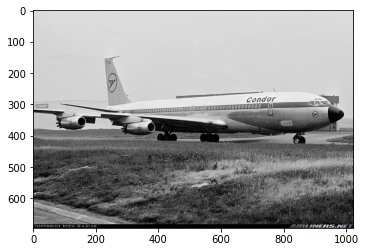

In [14]:
# show the image in manufacturer_df
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

# Function Show_image()

In [15]:
# the function :
# - take a df(argument)
#-take a row(row : argument)
#-take a column (target : argument)
# -it displays (the value of target ) and the associated image, for the line in argument


def show_image(df, row, target):
  """ Show an image from an image database , with the associated class

  Parameters
  -----------
  df(pd.DataFrame): images definition dataframe
  row(int):row index in df of image to be displayed
  target(str):name of target column

  Returns
  --------
  None
  """
  assert target in df.columns, "missing target column in dataframe"
  assert 'path' in df.columns , "Missing image path in dataframe"
  print(df.iloc[row, ][target])
  plt.imshow(plt.imread(df.iloc[row, ]['path']))
  return

# Function load_resize_image()

In [16]:
def load_resize_image(path,height,width):
  """Load an image and resize it to the target size
    Parameters
    --------
    path(Path): access path to image file
    height(int): resize image to this height
    width(int):resize image to this width

    Returns
    ----------
    nb.array containing resize



  """
  
  return np.array(Image.open(path).resize((width, height)))

# Function build_classifiaction_model()

In [17]:
def build_classification_model(df:pd.DataFrame, target:str, images:str):
  """Build a TF model using information from target and images columns in dataframe

  Parameters
  ---------------
  df(pd.Dataframe):dataframe with target and images columns
  target(str):column name for target variable
  images(str):column name for images


  Returns
  -----------
  TF model built & compiled
  """
  nb_classes=df[target].nunique()# compute number of classees for output layer
  size = df[images].iloc[0].shape# com
  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax'))# couche de sortie à nb_classes

  # #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Function build_x_and_y()

Build train & test set

In [18]:
def build_x_and_y(df:pd.DataFrame,target:str,images:str,stratify=None):
  """Build x tensor and y tensor for model fitting 

  Parameters
  --------------
  df(pd.DataFrame):dataframe contanining images and target
  target(str):name of target column
  images(str): name of images column
  
  Returns
  ---------
  x(np.array):tensor of x values
  y(np.array):name of y values
  """
  x=np.array(df[images].to_list())
  y= tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  y_svm = np.array(df[target].astype("category").cat.codes)
 

  return x, y, y_svm


In [19]:
# Load train & test dataset

train_df= build_image_database(DATA_DIR_TRAIN_FAMILY,TARGET_NAME2)
test_df= build_image_database(DATA_DIR_TEST_FAMILY,TARGET_NAME2)

train_df['resized_image']=train_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

test_df['resized_image']=test_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)
#train_df
# Build tensors for training & testing

X_train,y_train,y_train_svm = build_x_and_y(train_df,TARGET_NAME2,'resized_image')
X_test,y_test,y_test_svm = build_x_and_y(test_df,TARGET_NAME2,'resized_image')

# BUILD TF classification model
model = build_classification_model(train_df,TARGET_NAME2,'resized_image')


In [20]:
# To be done once to retrieve the TPU information
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.10.249.74:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.10.249.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.249.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [21]:
with tpu_strategy.scope():
  model= build_classification_model(train_df, TARGET_NAME2, 'resized_image')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36928     
                                                      

In [22]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    #callbacks=[tensorboard_callback]
                    )

Epoch 1/30
35/35 [==============================] - 38s 786ms/step - loss: 17.2713 - accuracy: 0.1758 - val_loss: 3.1503 - val_accuracy: 0.2202
Epoch 2/30
35/35 [==============================] - 3s 80ms/step - loss: 3.0556 - accuracy: 0.2109 - val_loss: 2.9322 - val_accuracy: 0.2205
Epoch 3/30
35/35 [==============================] - 3s 81ms/step - loss: 2.9243 - accuracy: 0.2148 - val_loss: 2.9126 - val_accuracy: 0.2196
Epoch 4/30
35/35 [==============================] - 3s 81ms/step - loss: 2.8144 - accuracy: 0.2163 - val_loss: 2.7602 - val_accuracy: 0.2208
Epoch 5/30
35/35 [==============================] - 3s 81ms/step - loss: 2.6359 - accuracy: 0.2484 - val_loss: 2.6907 - val_accuracy: 0.2277
Epoch 6/30
35/35 [==============================] - 3s 81ms/step - loss: 2.4576 - accuracy: 0.2777 - val_loss: 2.5886 - val_accuracy: 0.2499
Epoch 7/30
35/35 [==============================] - 3s 81ms/step - loss: 2.2627 - accuracy: 0.3212 - val_loss: 2.5439 - val_accuracy: 0.2610
Epoch 8/30

In [23]:
# verify the shape

X_test[10:11].shape

(1, 128, 128, 3)

In [24]:
# the prediction of X_test[10:11]
np.argmax(model.predict(X_test[10:11]))

4

In [25]:
# the probabilty of prediction of X_test[10:11]
model.predict(X_test[10:11])

array([[1.92362163e-03, 2.56060213e-02, 2.78882908e-05, 3.16205915e-05,
        6.40735745e-01, 5.63369322e-05, 8.68420466e-06, 1.13966828e-03,
        2.78510142e-05, 5.80725477e-08, 5.28164355e-06, 1.18831216e-04,
        1.03134913e-02, 4.45385538e-02, 1.44045191e-06, 1.56752230e-05,
        2.89727421e-03, 1.41779927e-03, 3.72747920e-04, 1.08062675e-04,
        4.95313434e-05, 2.67447103e-02, 4.35524387e-04, 1.49793316e-08,
        7.37183257e-08, 3.44962638e-04, 9.50968097e-05, 2.42437661e-01,
        2.05613163e-04, 3.40210012e-04]], dtype=float32)

In [26]:
# see the categorisation of modality of manufacturer
test_df[TARGET_NAME2].astype('category').cat.codes

0        4
1        4
2        4
3        4
4        4
        ..
3328    28
3329    28
3330    28
3331    28
3332    28
Length: 3333, dtype: int8

In [27]:
# see the modality of manaufacturer
test_df[TARGET_NAME2]

0         Boeing
1         Boeing
2         Boeing
3         Boeing
4         Boeing
          ...   
3328    Yakovlev
3329    Yakovlev
3330    Yakovlev
3331    Yakovlev
3332    Yakovlev
Name: manufacturer, Length: 3333, dtype: object

Boeing


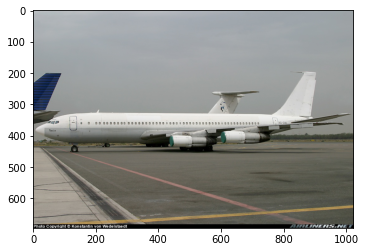

In [28]:
# show image of the row equal to 10 for the target manufacturer
show_image(test_df, 10, TARGET_NAME2)

In [29]:
# the prediction of X_test[10:20
#np.argmax(model.predict(X_test[10:20]), axis=1)

In [30]:
# see the modality from the categorisation
train_df[TARGET_NAME2].astype('category').cat.categories

Index(['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland'],
      dtype='object')

# fucntion of the classify_image()

In [31]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.
  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/ Keras model
  classes_names: dictionnary with classes names
  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

In [32]:
# verification of the shape of the function classify_image()
classify_images(X_test, model).shape

(3333,)

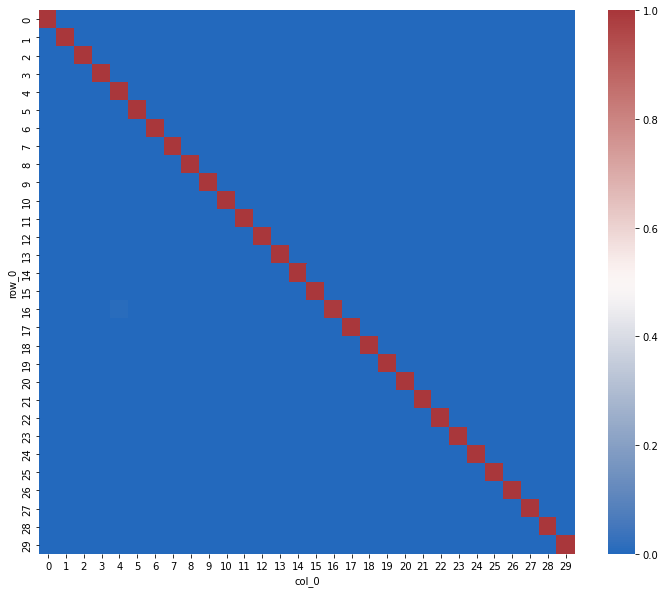

In [33]:
# see the confusion matrix in the train
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), 
                        classify_images(X_train, model), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

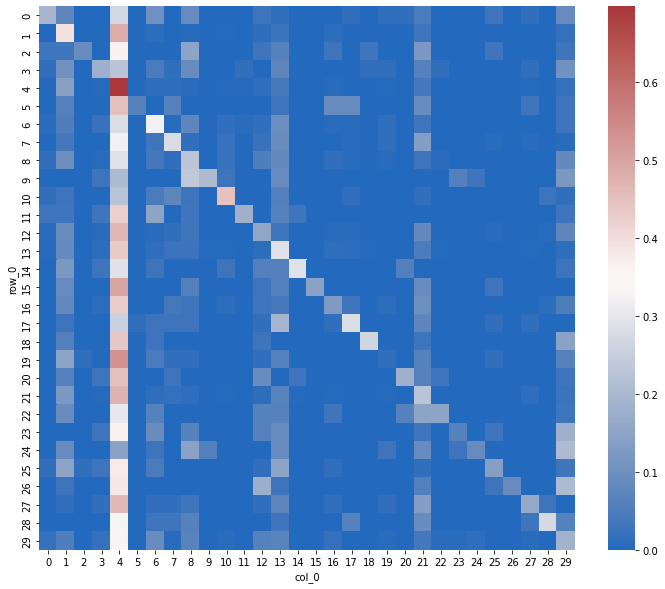

In [34]:
# see the confusion matrix of the test
#we can see our model classifies genelrally the planes in 4

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1), 
                        classify_images(X_test, model), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

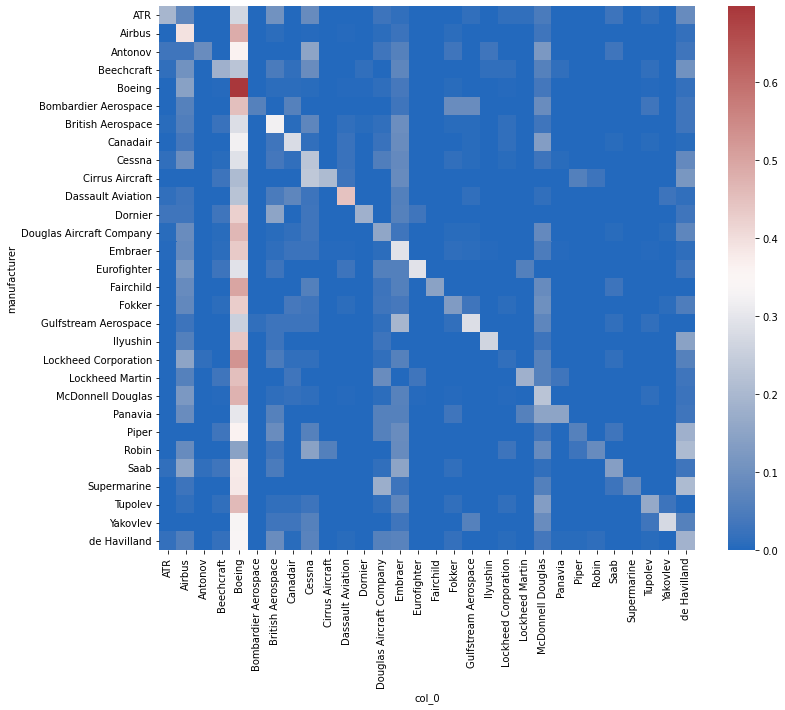

In [35]:
# see the confusion matrix of the test
#we can see our model classifies genelrally the planes in Boeing

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME2], 
                        classify_images(X_test, model, test_df[TARGET_NAME2].astype('category').cat.categories), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

In [36]:
# function to save_model
import datetime
def save_model(model, basename):
  """Save tf/Keras model

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}.h5'.format(basename))
  return

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# apply the function save_model()
save_model(model, TARGET_NAME2)

In [39]:
# relodded the model
#reloaded_model = load_model('/content/dataset/data_2022-04-05_19-38-28.h5')

In [40]:
# prediction with the model reloaded
#np.argmax(reloaded_model.predict(X_test[10:20]), axis=1)

## IMAGE CLASSIFICATION WITH SVM

In [41]:
# Suppert vector machine:

svc = SVC(kernel="linear", gamma = "auto")

In [42]:
# Create flatten base

X_train_scaled_s = X_train / 255
X_test_scaled_s = X_test / 255

In [43]:
# Take the len of our image

lenofimage = len(X_train_scaled_s)
lenofimagetest = len(X_test_scaled_s)

In [44]:
# Reshape our datasets

X_train_scaled_svc_s = X_train_scaled_s.reshape(lenofimage, -1)
X_test_scaled_svc_s = X_test_scaled_s.reshape(lenofimagetest, -1) 

In [45]:
# Fit the model

svc.fit(X_train_scaled_svc_s, y_train_svm)

SVC(gamma='auto', kernel='linear')

In [46]:
y_predict_train=svc.predict(X_train_scaled_svc_s)

In [47]:
# Make the model prediction

y_predict = svc.predict(X_test_scaled_svc_s)

In [48]:
# Print the accuracy of the model


print("The accuracy of the model is:", accuracy_score(y_test_svm,y_predict))

The accuracy of the model is: 0.285028502850285


In [49]:
# creating a confusion matrix

cm_lin = confusion_matrix(y_test_svm, y_predict)


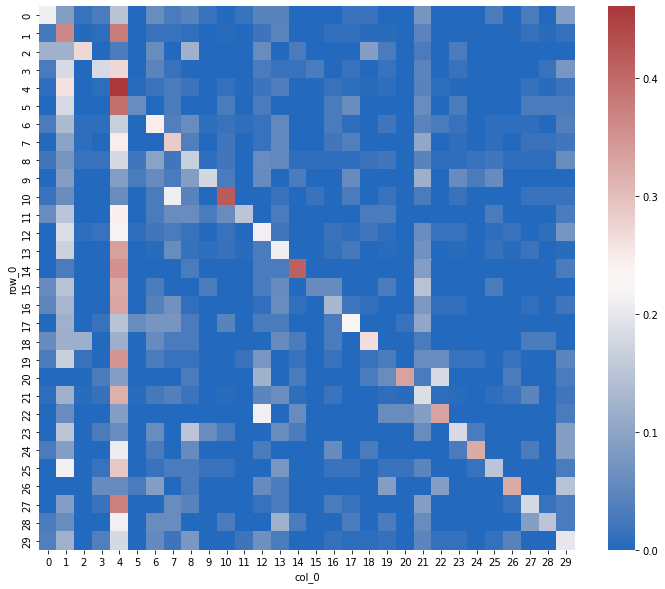

In [50]:
# Plot the confusion matrix with number

plt.figure(figsize=(12,10))
sns.heatmap(pd.crosstab(y_test_svm,  y_predict,
                        normalize='index'),
            cmap='vlag'
            )


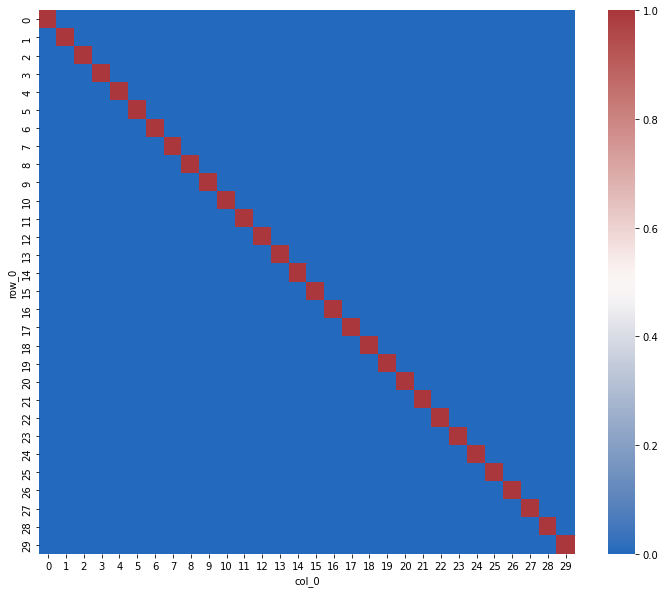

In [51]:
# see the confusion matrix in the train model with number

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(y_train_svm, 
                        y_predict_train, 
                        normalize='index'),
            cmap='vlag')
           

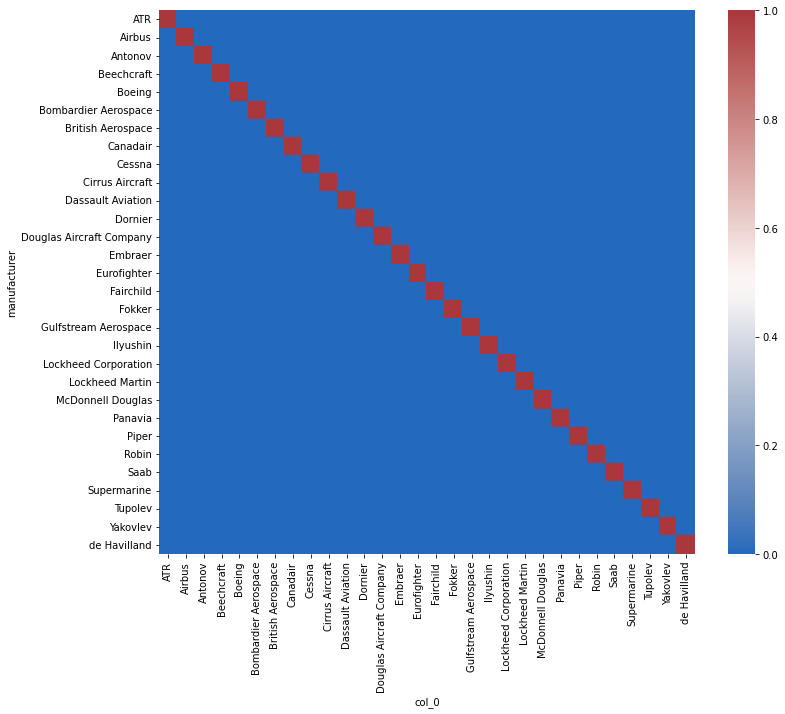

In [52]:
## See the confusion matrix of the train with namems


fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(train_df[TARGET_NAME2], 
                        train_df[TARGET_NAME2].astype('category').cat.categories[y_predict_train], 
                        normalize='index'),
            cmap='vlag')

In [53]:
test_df[TARGET_NAME2]

0         Boeing
1         Boeing
2         Boeing
3         Boeing
4         Boeing
          ...   
3328    Yakovlev
3329    Yakovlev
3330    Yakovlev
3331    Yakovlev
3332    Yakovlev
Name: manufacturer, Length: 3333, dtype: object

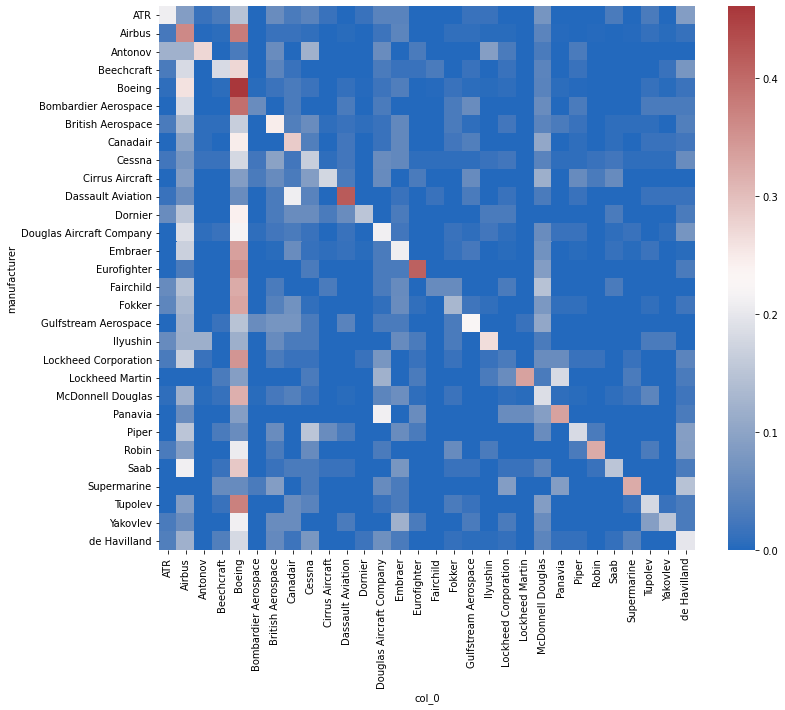

In [54]:
# See the confusion matrix of the test


fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME2],
                        test_df[TARGET_NAME2].astype('category').cat.categories[y_predict],
                        normalize='index'),
            cmap='vlag',
            );

In [55]:
#file_dir = '/content/drive/MyDrive/image_classifier/base_dir.h5'
#base_model.save(file_dir)

In [56]:
# Save the model

filename = "model_svm.sav"
pickle.dump(svc, open(filename,"wb"))

# Conlusion 

The accuracy of the SVM model in the training test is 28,50 % while it's 15,90 % when we use  our Neural Network model. It's quite strange since Neural Network should perform better. Then we can suspect bad specification in our Neural Network model. 
